<a href="https://colab.research.google.com/github/Salma-Jamal/Quotes-Recommendation-System/blob/main/model/Quotes-Recommendation-System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quotes Recommendation System
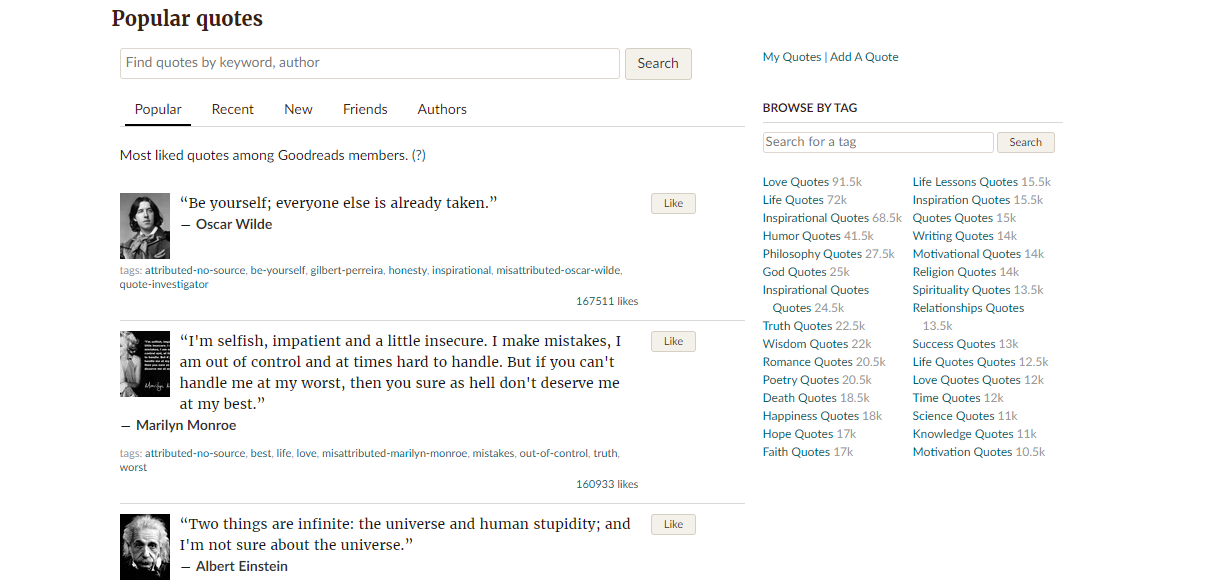

In [ ]:
!pip install datasets
!pip install transformers

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import torch
import random
from datasets import load_dataset
import re

In [3]:
dataset = load_dataset("Abirate/english_quotes")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/Abirate___json/Abirate--english_quotes-6e72855d06356857/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['quote', 'author', 'tags'],
        num_rows: 2508
    })
})

In [22]:
dataset['train']['quote'][1]

"“I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.”"

In [23]:
dataset['train']['tags'][1]

['best', 'life', 'love', 'mistakes', 'out-of-control', 'truth', 'worst']

In [24]:
categories = ['love','inspirational', 'life', 'humor', 'books','inspiration','poetry','hope','reading','happiness','writing','inspirational-quotes','friendship','wisdom','truth','philosophy','romance','other']
id2label = {idx:label for idx, label in enumerate(categories)}
label2id = {label:idx for idx, label in enumerate(categories)}
categories

['love',
 'inspirational',
 'life',
 'humor',
 'books',
 'inspiration',
 'poetry',
 'hope',
 'reading',
 'happiness',
 'writing',
 'inspirational-quotes',
 'friendship',
 'wisdom',
 'truth',
 'philosophy',
 'romance',
 'other']

In [25]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(categories),  problem_type="multi_label_classification",id2label=id2label,label2id=label2id )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [44]:
def map_tags(quote_tags):
  quote_tags = [tag for tag in quote_tags if tag in categories]
  if len(quote_tags) == 0:
    quote_tags = ['other']

  label = [0]*len(categories)

  for tag in quote_tags:
    index = categories.index(tag)
    label[index] = 1
  return label

In [45]:
map_tags(['friendship', 'humor', 'romance'])

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]

In [32]:
def clean_quotes(text):
    # remove any non-alphanumeric characters except spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # convert to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text

In [35]:
clean_quotes('Hello! my name is ahmed')

'hello my name is ahmed'

In [47]:
# Define the dataset class
class QuoteDataset(Dataset):
  def __init__(self, dataset, tokenizer):
    self.quotes = dataset['train']['quote']
    self.targets = list(map(map_tags,dataset['train']['tags']))
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.quotes)
  
  def __getitem__(self, index):
    quote = self.quotes[index]
    target = self.targets[index]
    
    cleaned = clean_quotes(quote)
    inputs = self.tokenizer(cleaned, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    
    # label = [0]*len(categories)
    
    # for t in target:
    #   label[categories.index(t)] = 1
    # label = torch.tensor(label)
    label = torch.tensor(target)
    
    return {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0],
            'labels': label.float()
        }

In [48]:
train_dataset = QuoteDataset(dataset, tokenizer)

In [52]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=2e-5,
    save_steps=1000
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

In [53]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.248000
1000,0.189300
1500,0.165600
2000,0.142000
2500,0.121900
3000,0.106800


TrainOutput(global_step=3135, training_loss=0.15981804757977597, metrics={'train_runtime': 393.7572, 'train_samples_per_second': 31.847, 'train_steps_per_second': 7.962, 'total_flos': 824971654932480.0, 'train_loss': 0.15981804757977597, 'epoch': 5.0})

## Testing

In [54]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [55]:
# Load the test dataset
test = pd.read_csv("/content/test.csv")
test.head()

,quote
0,“If you don't stand for something you will fal...
1,"“I may not have gone where I intended to go, b..."
2,"“I love you without knowing how, or when, or f..."
3,“I solemnly swear that I am up to no good.”
4,"“Outside of a dog, a book is man's best friend..."


In [59]:
test['quote'] = test['quote'].apply(clean_quotes)

### Recommend quotes by topic

In [60]:
def preprocess_quote(quotes):
  inputs = tokenizer(quotes, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
  return {
      'input_ids': inputs['input_ids'][0],
      'attention_mask': inputs['attention_mask'][0]
  }

In [ ]:
test_inputs = [preprocess_quote(quote) for quote in test['quote'].tolist()]
test_outputs = trainer.predict(test_inputs)

In [84]:
test_outputs.predictions[:5]

array([[-4.0733337 , -3.4068148 , -3.5996115 , -3.195685  , -4.511278  ,
        -4.7214966 , -4.2457576 , -4.10249   , -4.7730317 , -4.764405  ,
        -4.5520797 , -4.8376713 , -4.2317233 , -4.2395167 , -4.357439  ,
        -3.639615  , -4.82502   ,  2.5704725 ],
       [-2.494349  ,  0.21704766,  0.5153575 , -3.3567617 , -3.9601555 ,
        -1.9009067 , -3.9590845 , -3.1163714 , -4.140316  , -2.3163035 ,
        -4.178997  , -2.0480938 , -3.067273  , -2.9644382 , -3.5863094 ,
        -3.340728  , -4.253899  , -2.9497874 ],
       [ 2.0250862 , -2.5084615 , -2.7313116 , -3.4898677 , -4.034753  ,
        -3.3980992 , -3.3671029 , -3.4758193 , -4.097503  , -3.5436606 ,
        -4.26826   , -4.003549  , -2.6920733 , -4.1845036 , -3.3888    ,
        -4.312429  , -2.1545076 , -2.9333086 ],
       [-4.082066  , -3.6801565 , -3.832824  , -2.7665577 , -4.3347654 ,
        -4.728571  , -4.229418  , -4.1050663 , -4.6277175 , -4.888185  ,
        -4.518355  , -4.9758077 , -4.335273  , -4.251

In [63]:
def convert_predictions(preds):

  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(preds))
  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs >= 0.50)] = 1
  
  return y_pred

In [64]:
y_pred = convert_predictions(test_outputs.predictions)

In [85]:
y_pred[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [66]:
def Recommend_quotes_by_topic(inputs_text,outputs,topic):

  topic_vector = [1 if i in topic else 0 for i in categories]

  similarity_scores = cosine_similarity(outputs, [topic_vector])

  # Sort the rows in descending order based on the similarity score
  indices = np.argsort(similarity_scores, axis=0)[::-1].squeeze()

  # Print the rows in descending order of similarity
  for i in indices[:10]:
    print(' Quote:',inputs_text[i],'\n','Score:',similarity_scores[i])
    print("\n")
    print("*"*100)

In [72]:
Recommend_quotes_by_topic(test['quote'].tolist(),y_pred,['inspirational'])

 Quote: today you are you that is truer than true there is no one alive who is youer than you 
 Score: [1.]


****************************************************************************************************
 Quote: you have brains in your head you have feet in your shoes you can steer yourself any direction you choose youre on your own and you know what you know and you are the one wholl decide where to go 
 Score: [0.70710678]


****************************************************************************************************
 Quote: i may not have gone where i intended to go but i think i have ended up where i needed to be 
 Score: [0.70710678]


****************************************************************************************************
 Quote: i am enough of an artist to draw freely upon my imagination imagination is more important than knowledge knowledge is limited imagination encircles the world 
 Score: [0.70710678]


**********************************************

In [83]:
Recommend_quotes_by_topic(test['quote'].tolist(),y_pred,['life','hope'])

 Quote: this life is what you make it no matter what youre going to mess up sometimes its a universal truth but the good part is you get to decide how youre going to mess it up girls will be your friends  theyll act like it anyway but just remember some come some go the ones that stay with you through everything  theyre your true best friends dont let go of them also remember sisters make the best friends in the world as for lovers well theyll come and go too and baby i hate to say it most of them  actually pretty much all of them are going to break your heart but you cant give up because if you give up youll never find your soulmate youll never find that half who makes you whole and that goes for everything just because you fail once doesnt mean youre gonna fail at everything keep trying hold on and always always always believe in yourself because if you dont then who will sweetie so keep your head high keep your chin up and most importantly keep smiling because lifes a beautiful thin

### Recommend similar quotes

In [76]:
quote = 'we accept the love we think we deserve'
cleaned_quote = clean_quotes(quote)
quote_inputs = preprocess_quote(cleaned_quote)
quote_outputs = trainer.predict([quote_inputs])
quote_pred  = convert_predictions(quote_outputs.predictions)
quote_pred

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [77]:
def Recommend_similar_quotes(inputs_text,quote,list_quotes):

  similarity_scores = cosine_similarity(list_quotes, quote)

  # Sort the rows in descending order based on the similarity score
  indices = np.argsort(similarity_scores, axis=0)[::-1].squeeze()

  # Print the rows in descending order of similarity
  for i in indices[:10]:
    print(' Quote:',inputs_text[i],'\n','Score:',similarity_scores[i])
    print("\n")
    print("*"*100)

In [78]:
Recommend_similar_quotes(test['quote'].tolist(),quote_pred,y_pred)

 Quote: you may not be her first her last or her only she loved before she may love again but if she loves you now what else matters shes not perfectyou arent either and the two of you may never be perfect together but if she can make you laugh cause you to think twice and admit to being human and making mistakes hold onto her and give her the most you can she may not be thinking about you every second of the day but she will give you a part of her that she knows you can breakher heart so dont hurt her dont change her dont analyze and dont expect more than she can give smile when she makes you happy let her know when she makes you mad and miss her when shes not there 
 Score: [1.]


****************************************************************************************************
 Quote: i love you without knowing how or when or from where i love you simply without problems or pride i love you in this way because i do not know any other way of loving but this in which there is no i o